/home/tanke/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


UMPM
step 1: elapsed 0.38457250595092773
step 2: elapsed 0.010144948959350586
step 3: elapsed 0.046605825424194336
step 4: elapsed 0.4740335941314697
-------------------------------------------
Handle transitivity:
	Intra:		 2
	Intra(choice):	 3
	Inter:		 63
	Inter(choice):	 43
-------------------------------------------
	Time =  72  ms
	result: 0

	Total cost: 132.09741364059838

# valid points:		 84
# invalid points:	 8
step 5: elapsed 0.07657551765441895
(smart candidate selection) [
	Time =  11  ms
	result: 0

	Total cost: 11.493514115901133
] (smart candidate selection)
step 6: elapsed 0.023863792419433594

total elapsed: 1.0165510177612305


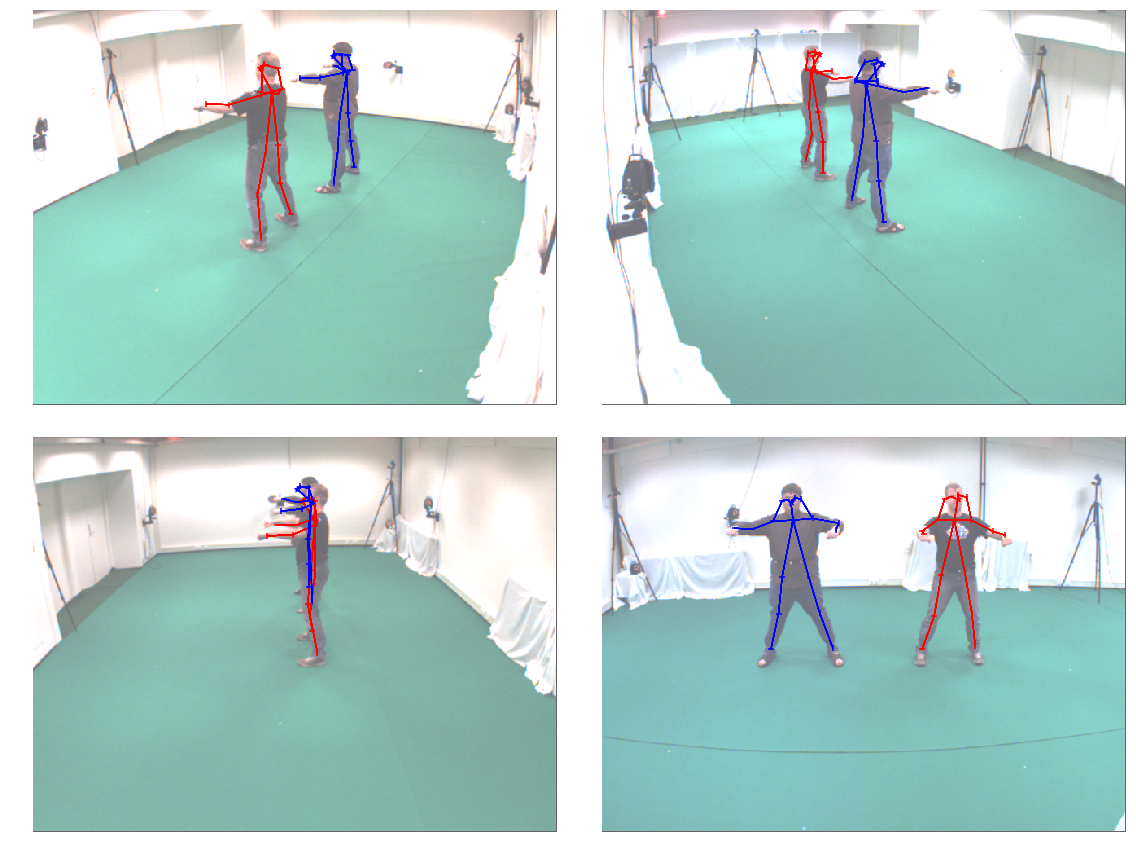

In [1]:
%matplotlib inline
# ---- settings ----
import json
Settings = json.load(open('../settings.txt'))
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import sys
sys.path.insert(0, '../'); sys.path.insert(0, '../samples')
import paf_loader
from os.path import join, isdir
import numpy as np
import cv2
from cselect import color as cs
from time import time
from mvpose import settings

from mvpose.data import umpm

params = settings.get_settings(ms_radius=30)
root = join(Settings['data_root'], 'pak')
user = Settings['UMPM']['username']
pwd = Settings['UMPM']['password']
tmp = Settings['tmp']

FRAME = 1430
FRAME = 0

X, Y, Calib = umpm.get(root, 'p2_free_1', user, pwd)

Im = np.array([X[0][FRAME], X[1][FRAME], X[2][FRAME], X[3][FRAME]])

heatmaps, pafs = paf_loader.load_confidence_map_and_paf('umpm', Im, 
                                                        FRAME, 
                                                        dir=tmp)

# ====================================
from mvpose import pose

_start = time()
Debug, detections = pose.estimate(
    Calib, heatmaps, pafs, settings=params, debug=True)
_end = time()
print('\ntotal elapsed:', _end - _start)
# ====================================

from mvpose.algorithm.candidate_selection import project_human_to_2d
from mvpose.plot.limbs import draw_mscoco_human

def normalize_score(score):
    return np.ones_like(score) * 0.5

Humans = detections

fig = plt.figure(figsize=(16,12))

colors = ['red', 'blue', 'green']

for idx, cam in enumerate(Calib):
    ax = fig.add_subplot(2,2,1+idx)
    ax.axis('off')
    im = Im[idx]
    h,w,_ = im.shape
    ax.imshow(im, alpha=0.6)
    
    for pid, human in enumerate(Humans):
        draw_mscoco_human(ax, human, cam, color=colors[pid])
    
plt.tight_layout()
plt.show()

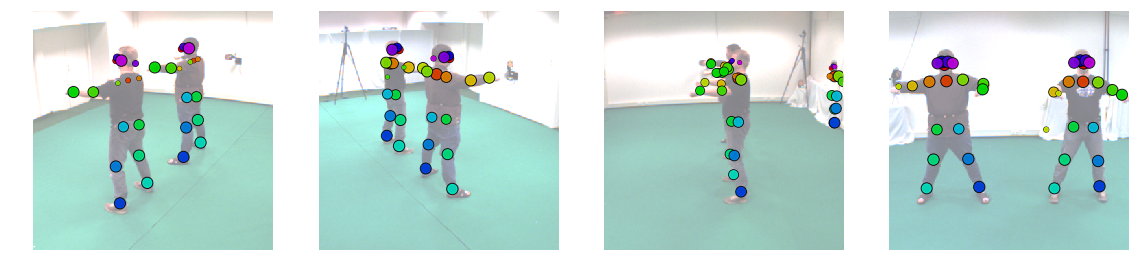

In [2]:
colors = cs.lincolor(22)/255

fig = plt.figure(figsize=(16,12))
for cid, im in enumerate(Im):
    ax = fig.add_subplot(1, 4, cid+1)
    ax.axis('off')
    ax.imshow(im, alpha=0.5)
    h,w,_ = im.shape
    ax.set_xlim([0, w])
    ax.set_ylim([h, 0])
    cam = Calib[cid]
    
    if cid == 0:
        ax.set_xlim([150, 500])
        ax.set_ylim([350, 0])
    elif cid == 1:
        ax.set_xlim([150, 500])
        ax.set_ylim([350, 0])
    elif cid == 2:
        ax.set_xlim([150, 500])
        ax.set_ylim([350, 0])
    elif cid == 3:
        ax.set_xlim([150, 500])
        ax.set_ylim([350, 0])
    
    for jid in range(Debug.candidates2d.n_joints):
        centers2d_with_w = Debug.candidates2d.peaks2d[cid][jid]
        if len(centers2d_with_w) == 0:
            continue
        centers2d = centers2d_with_w[:,0:2].astype('float32')
        score = centers2d_with_w[:,2]
        for p2d in centers2d:
            if p2d is not None:
                x, y = p2d
                ax.scatter(x, y, color='black', s=score*150, alpha=0.8)
                ax.scatter(x, y, color=colors[jid], s=score*100, alpha=0.8)
    
plt.tight_layout()
plt.show()

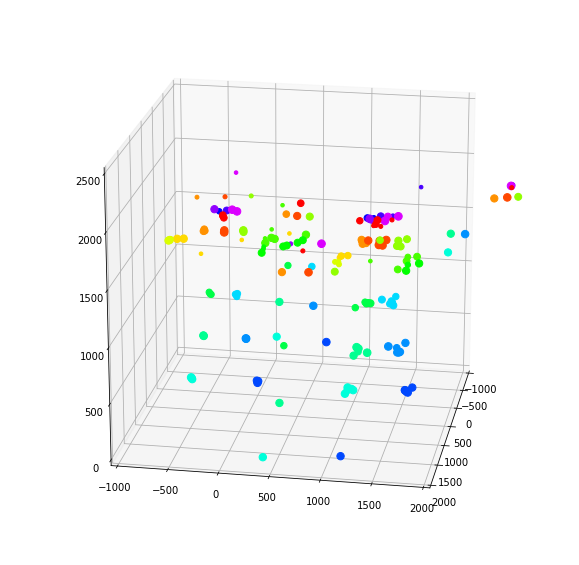

In [3]:
from mpl_toolkits.mplot3d import Axes3D
import numpy.linalg as la
from mvpose.data.default_limbs import DEFAULT_LIMB_SEQ, DEFAULT_SENSIBLE_LIMB_LENGTH

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
    
def plot1a(ax):
    ax.view_init(20, 10)

    for jid in range(Debug.candidates2d.n_joints):
        centers3d_with_w = Debug.triangulation.peaks3d_weighted[jid]
        centers3d = centers3d_with_w[:,0:3].astype('float32')
        score = np.exp(centers3d_with_w[:,3])**2
        ax.scatter(centers3d[:,0], centers3d[:,1], centers3d[:,2],
                  color=colors[jid], s=score*10, alpha=1)

    ax.set_xlim([-1000, 2000])
    ax.set_ylim([-1000, 2000])
    ax.set_zlim([0, 2500])
    
plot1a(ax)
plt.show()

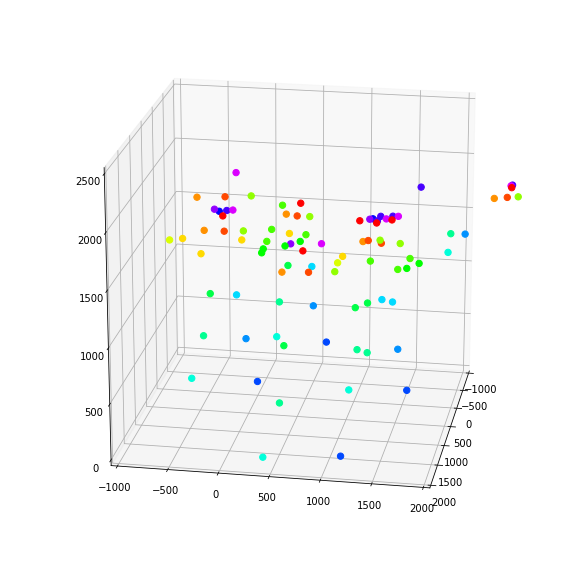

In [4]:
from mpl_toolkits.mplot3d import Axes3D
import numpy.linalg as la
from mvpose.data.default_limbs import DEFAULT_LIMB_SEQ, DEFAULT_SENSIBLE_LIMB_LENGTH

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
    
def plot1(ax):
    ax.view_init(20, 10)

    for jid in range(Debug.candidates2d.n_joints):
        centers3d_with_w = Debug.meanshift.centers3d[jid]
        centers3d = centers3d_with_w[:,0:3].astype('float32')
        score = centers3d_with_w[:,3]
        score = normalize_score(score)
        ax.scatter(centers3d[:,0], centers3d[:,1], centers3d[:,2],
                  color=colors[jid], s=score*80, alpha=1)

    ax.set_xlim([-1000, 2000])
    ax.set_ylim([-1000, 2000])
    ax.set_zlim([0, 2500])
    
plot1(ax)
plt.show()

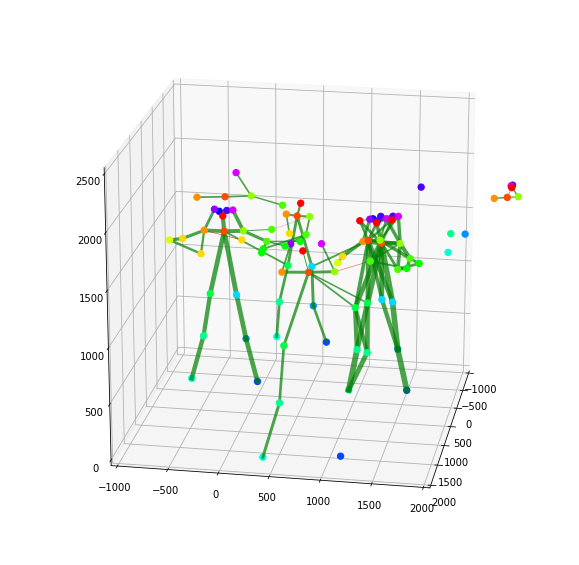

In [5]:
from mpl_toolkits.mplot3d import Axes3D
import numpy.linalg as la
from mvpose.data.default_limbs import DEFAULT_LIMB_SEQ, DEFAULT_SENSIBLE_LIMB_LENGTH

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

def plot2(ax):
    ax.view_init(20, 10)

    for jid in range(Debug.candidates2d.n_joints):
        centers3d_with_w = Debug.meanshift.centers3d[jid]
        centers3d = centers3d_with_w[:,0:3].astype('float32')
        score = centers3d_with_w[:,3]
        score = normalize_score(score)
        ax.scatter(centers3d[:,0], centers3d[:,1], centers3d[:,2],
                  color=colors[jid], s=score*80, alpha=1)


    # for (a, b), (emin, emax) in zip(DEFAULT_LIMB_SEQ, DEFAULT_SENSIBLE_LIMB_LENGTH):
    #     pts3d_A = Debug.meanshift.centers3d[a]
    #     pts3d_B = Debug.meanshift.centers3d[a]

    for lid, (a, b) in enumerate(DEFAULT_LIMB_SEQ):
        candA = Debug.meanshift.centers3d[a][:,0:3]
        candB = Debug.meanshift.centers3d[b][:,0:3]
        W = Debug.limbs3d[lid]
        n, m = W.shape
        assert n == len(candA) and m == len(candB)

        for _a in range(len(candA)):
            for _b in range(len(candB)):
                w = W[_a,_b]
                Ax,Ay,Az = candA[_a]
                Bx,By,Bz = candB[_b]
                if w > 0:
                    ax.plot([Ax,Bx], [Ay,By], [Az,Bz], color='green', linewidth=w*9, alpha=0.7)
                elif w > -99999:
                    ax.plot([Ax,Bx], [Ay,By], [Az,Bz], color='red', linewidth=-w*9, alpha=0.7)



    ax.set_xlim([-1000, 2000])
    ax.set_ylim([-1000, 2000])
    ax.set_zlim([0, 2500])
    
plot2(ax)
plt.show()

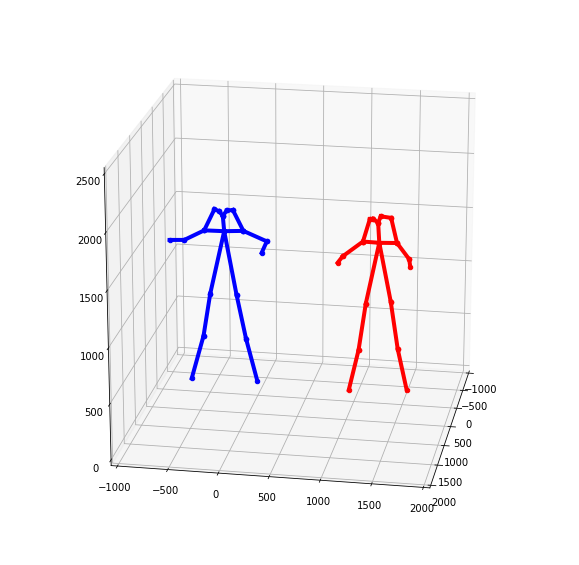

In [9]:
colorsH = ['red', 'blue']

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

def plot3(ax):

    ax.view_init(20, 10)




#     for jid in range(Debug.candidates2d.n_joints):
#         centers3d_with_w = Debug.meanshift.centers3d[jid]
#         centers3d = centers3d_with_w[:,0:3].astype('float32')
#         score = centers3d_with_w[:,3]
#         score = normalize_score(score)
#         ax.scatter(centers3d[:,0], centers3d[:,1], centers3d[:,2],
#                   color=colors[jid], s=score*100, alpha=0.2)


    # for (a, b), (emin, emax) in zip(DEFAULT_LIMB_SEQ, DEFAULT_SENSIBLE_LIMB_LENGTH):
    #     pts3d_A = Debug.meanshift.centers3d[a]
    #     pts3d_B = Debug.meanshift.centers3d[a]

#    for lid, (a, b) in enumerate(DEFAULT_LIMB_SEQ):
#         candA = Debug.meanshift.centers3d[a][:,0:3]
#         candB = Debug.meanshift.centers3d[b][:,0:3]
#         W = Debug.limbs3d[lid]
#         n, m = W.shape
#         assert n == len(candA) and m == len(candB)

#         for _a in range(len(candA)):
#             for _b in range(len(candB)):
#                 w = W[_a,_b]
#                 Ax,Ay,Az = candA[_a]
#                 Bx,By,Bz = candB[_b]
#                 if w > 0:
#                     ax.plot([Ax,Bx], [Ay,By], [Az,Bz], color='green', 
#                             linewidth=w*9, alpha=0.1)
#                 elif w > -99999:
#                     ax.plot([Ax,Bx], [Ay,By], [Az,Bz], color='red', 
#                             linewidth=-w*9, alpha=0.1)



    for pid, human in enumerate(Humans):
        color = colorsH[pid]
        for lid, (a, b) in enumerate(DEFAULT_LIMB_SEQ):
            candA = human[a]
            candB = human[b]
            ax.scatter(*candA, color=color)
            ax.scatter(*candB, color=color)
            ax.plot([candA[0], candB[0]], 
                   [candA[1], candB[1]],
                   [candA[2], candB[2]], color=color, linewidth=4)

    ax.set_xlim([-1000, 2000])
    ax.set_ylim([-1000, 2000])
    ax.set_zlim([0, 2500])
    
plot3(ax)
plt.show()

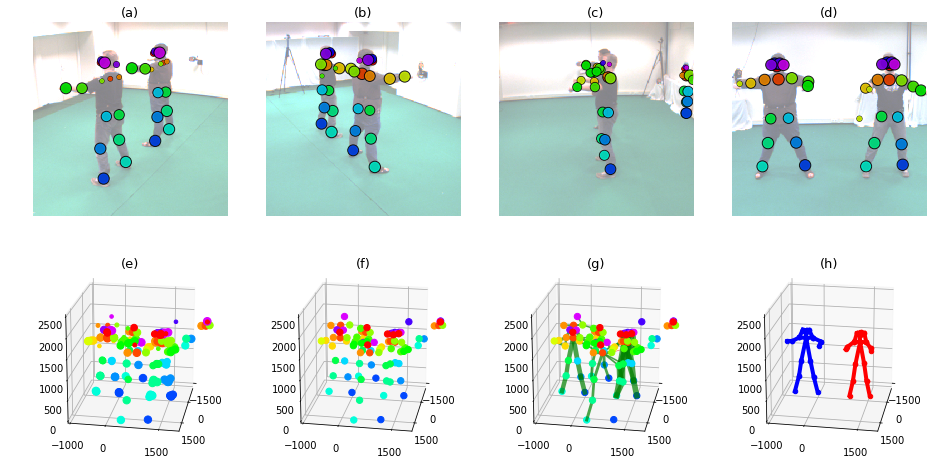

In [10]:
fontsize = 13

fig = plt.figure(figsize=(16, 8))

for cid, im in enumerate(Im):
    ax = fig.add_subplot(2, 4, cid+1)
    ax.axis('off')
    ax.imshow(im, alpha=0.5)
    h,w,_ = im.shape
    ax.set_xlim([0, w])
    ax.set_ylim([h, 0])
    cam = Calib[cid]
    
    if cid == 0:
        ax.set_xlim([150, 500])
        ax.set_ylim([350, 0])
        ax.set_title('(a)', fontsize=fontsize)
    elif cid == 1:
        ax.set_xlim([150, 500])
        ax.set_ylim([350, 0])
        ax.set_title('(b)', fontsize=fontsize)
    elif cid == 2:
        ax.set_xlim([150, 500])
        ax.set_ylim([350, 0])
        ax.set_title('(c)', fontsize=fontsize)
    elif cid == 3:
        ax.set_xlim([150, 500])
        ax.set_ylim([350, 0])
        ax.set_title('(d)', fontsize=fontsize)
    
    for jid in range(Debug.candidates2d.n_joints):
        centers2d_with_w = Debug.candidates2d.peaks2d[cid][jid]
        if len(centers2d_with_w) == 0:
            continue
        centers2d = centers2d_with_w[:,0:2].astype('float32')
        score = centers2d_with_w[:,2]
        for p2d in centers2d:
            if p2d is not None:
                x, y = p2d
                ax.scatter(x, y, color='black', s=score*150, alpha=0.8)
                ax.scatter(x, y, color=colors[jid], s=score*100, alpha=0.8)

# ----------------------------------

#fig = plt.figure(figsize=(16, 10))
ax = fig.add_subplot(245, projection='3d')
ax.set_title('(e)', fontsize=fontsize)
ax.set_xticks([-1500, 0, 1500])
ax.set_yticks([-1000, 0, 1500])
plot1a(ax)


ax = fig.add_subplot(246, projection='3d')
ax.set_title('(f)', fontsize=fontsize)
ax.set_xticks([-1500, 0, 1500])
ax.set_yticks([-1000, 0, 1500])
plot1(ax)

ax = fig.add_subplot(247, projection='3d')
ax.set_title('(g)', fontsize=fontsize)
ax.set_xticks([-1500, 0, 1500])
ax.set_yticks([-1000, 0, 1500])
plot2(ax)

ax = fig.add_subplot(248, projection='3d')
ax.set_title('(h)', fontsize=fontsize)
ax.set_xticks([-1500, 0, 1500])
ax.set_yticks([-1000, 0, 1500])
plot3(ax)

# ----------------------------------

# for idx, cam in enumerate(Calib):
#     ax = fig.add_subplot(3,4,9+idx)
#     ax.axis('off')
#     im = Im[idx]
#     h,w,_ = im.shape
#     ax.imshow(im, alpha=0.6)
    
#     if idx == 0:
#         ax.set_xlim([150, 500])
#         ax.set_ylim([350, 0])
#         ax.set_title('(h)', fontsize=fontsize)
#     elif idx == 1:
#         ax.set_xlim([150, 500])
#         ax.set_ylim([350, 0])
#         ax.set_title('(i)', fontsize=fontsize)
#     elif idx == 2:
#         ax.set_xlim([150, 500])
#         ax.set_ylim([350, 0])
#         ax.set_title('(j)', fontsize=fontsize)
#     elif idx == 3:
#         ax.set_xlim([150, 500])
#         ax.set_ylim([350, 0])
#         ax.set_title('(k)', fontsize=fontsize)
    
#     for pid, human in enumerate(Humans):
#         draw_mscoco_human(ax, human, cam, color=colorsH[pid])


#plt.tight_layout()
plt.show()

In [ ]:
fig = plt.figure(figsize=(16,12))

for idx, cam in enumerate(Calib):
    ax = fig.add_subplot(1,4,1+idx)
    ax.axis('off')
    im = Im[idx]
    h,w,_ = im.shape
    ax.imshow(im, alpha=0.6)
    
    for pid, human in enumerate(Humans):
        draw_mscoco_human(ax, human, cam, color=colorsH[pid])
    
plt.tight_layout()
plt.show()